In [157]:
# Licensed under a 3-clause BSD style license - see LICENSE.rst
"""Session class driving the high level interface API"""
import time

import logging
import yaml
import pandas as pd 
import json

import warnings
from pathlib import Path

from astropy.units import Quantity
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io.fits.verify import VerifyWarning

from gammapy.data import (
    Observation,
    DataStore,
    FixedPointingInfo, 
    PointingMode,
)
from gammapy.estimators import (
    FluxPoints, 
    SensitivityEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator,
    LightCurveEstimator,
)
from gammapy.makers import (
    FoVBackgroundMaker,
    MapDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)

from gammapy.utils.units import energy_unit_format
from gammapy.utils.pbar import progress_bar
from gammapy.utils.scripts import make_path, read_yaml

from gammapy.datasets import (
    Datasets,  
    MapDataset, 
    FluxPointsDataset, 
    SpectrumDatasetOnOff, 
    SpectrumDataset,
)

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    SkyModel, 
    Models,
    Model,
    DatasetModels, 
    FoVBackgroundModel, 
    Models, 
    SkyModel, 
    ExpCutoffPowerLawSpectralModel
)

from gammapy.maps import Map, MapAxis, RegionGeom, WcsGeom
from gammapy.stats import WStatCountsStatistic

from feupy.utils.datasets import flux_points_dataset_from_table, cut_energy_table_fp, write_datasets, read_datasets
from feupy.utils.observation import sensitivity_estimator
from feupy.utils.stats import StatisticalUtilityFunctions as stats
from feupy.utils.string_handling import name_to_txt
from feupy.utils.coordinates import skycoord_to_dict, skycoord_config_to_skycoord
from regions import CircleSkyRegion


from feupy.cta.irfs import Irfs

from feupy.roi import ROI
from feupy.target import Target

from feupy.catalog.pulsar.atnf import SourceCatalogATNF


# from feupy.analysis.config_sml import CTASimulationConfig

__all__ = ["CTASimulation"]


# In[ ]:


log = logging.getLogger(__name__)

class CTASimulation:
    """Config-driven high level CTASimulation interface.

    It is initialized by default with a set of configuration parameters and values declared in
    an internal high level interface model, though the user can also provide configuration
    parameters passed as a nested dictionary at the moment of instantiation. In that case these
    parameters will overwrite the default values of those present in the configuration file.

    Parameters
    ----------
    config : dict or `CTASimulationConfig`
        Configuration options following `CTASimulationConfig` schema
    """

    def __init__(self, config):
        self.config = config
        self.config.set_logging()
    
#         self._ctao_perf = Irfs
#         self._ctao_perf.get_irfs(self.config.observation.irfs_config)
        self.fit = Fit()
        self.fit_result = None
        self.flux_points = None
        self.datasets = None

    
    @property
    def config(self):
        """CTASimulation configuration (`CTASimulationConfig`)"""
        return self._config

    @config.setter
    def config(self, value):
        if isinstance(value, dict):
            self._config = CTASimulationConfig(**value)
        elif isinstance(value, CTASimulationConfig):
            self._config = value
        else:
            raise TypeError("config must be dict or CTASimulationConfig.")

    @property
    def models(self):
        if not self.datasets:
            raise RuntimeError("No datasets defined. Impossible to set models.")
        return self.datasets.models

    @models.setter
    def models(self, models):
        self.set_models(models, extend=False)
        
    def update_config(self, config):
        """Update the configuration."""
        self.config = self.config.update(config=config)
    
        
#     def compute_sensitivity():
#         log.info("computing sensitivity.")
#         spectrum, gamma_min, n_sigma, bkg_syst_fraction, dataset_onoff, sed_type="e2dnde", name="sens"
        
#         sens, sensitivity_table = sensitivity_estimator(
#             spectrum=spectrum,
#             gamma_min=gamma_min, 
#             n_sigma=n_sigma, 
#             bkg_syst_fraction=bkg_syst_fraction, 
#             dataset_onoff=dataset_onoff)
        
#         name = name.replace("model", "")
#         model_name = f"model sens {name}"
#         name = f"sens {name}"
       
#         sensitivity_ds = flux_points_dataset_from_table(
#             sensitivity_table, 
#             reference_model=spectrum.copy(),
#             sed_type=sed_type,
#             name=name,
#             model_name=model_name)

#         return sens, sensitivity_ds, sensitivity_table
    
    def create_observation(self):
        return self._create_observation(self)
    
    def _create_observation(self):
        """Create an observation."""
        on_region_settings = self.config.datasets.on_region
        observation_settings = self.config.observation
        
        on_lon = on_region_settings.lon
        on_lat = on_region_settings.lat
        on_center = SkyCoord(on_lon, on_lat, frame=on_region_settings.frame)
        print(f"\non_center:\n{on_center}\n")
        
        position_angle = observation_settings.pointing_angle
        separation = observation_settings.offset
        position = on_center
        pointing_position = self._create_pointing_position(position, position_angle, separation)
        print(f"\npointing_position:\n{pointing_position}\n")
        pointing = self._create_pointing(pointing_position)
        print(f"\npointing:\n{pointing}\n")
        livetime = observation_settings.livetime
        required_irfs = self.observation_settings.required_irfs
        irfs = Irfs.get_irfs(required_irfs)
        location = Irfs.get_obs_loc(required_irfs)
        
        observation = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs, location=location)
        print(f"\n{observation}\n")
        return observation
        
    @staticmethod
    def _create_pointing_position(position, position_angle, separation):
        """Create the pointing position"""
        return position.directional_offset_by(position_angle, separation)
    
    @staticmethod
    def _create_pointing(pointing_position):
        """Create the pointing."""
        return FixedPointingInfo(
            mode=PointingMode.POINTING,
            fixed_icrs=pointing_position.icrs,
        )
    
    
    def _create_geometry(self):
        """Create the geometry."""
        geom_settings = self.config.datasets.geom
        observations_settings = self.config.observation
        axes = [self._make_energy_axis(geom_settings.axes.energy)]
        center = skycoord_config_to_skycoord(self.config.target.position)
        radius = self.config.datasets.on_region_radius
        region = self._create_on_region(center, radius)
        return RegionGeom.create(region=region, axes=axes)
    
    @staticmethod
    def _make_energy_axis(config_axis_energy, per_decade=True):
        """Create the energy axis."""
        energy_axis = MapAxis.from_energy_bounds(        
            energy_min=config_axis_energy.min, 
            energy_max=config_axis_energy.max, 
            nbin=config_axis_energy.nbins, 
            per_decade=per_decade, 
            name=config_axis_energy.name,
            )
        return energy_axis
    
    @staticmethod
    def _create_on_region(center, radius):
        """Create the region geometry."""
        return CircleSkyRegion(
            center=center, 
            radius=radius
        )
    
    
    def create_spectrum_dataset_empty(self, name="obs-0"):
        log.info(f'***\nCreating a Spectrum Dataset object with zero filled maps.***')
        geom_settings = self.config.datasets.geom
        self.geom = self._create_geometry()
        log.info(f"\n{self.geom}\n")
        energy_axis_true = self._make_energy_axis(geom_settings.axes.energy_true)
        log.info(f"\n{energy_axis_true}\n")
        self.dataset_empty = SpectrumDataset.create(geom=self.geom, energy_axis_true=energy_axis_true, name=name)
        log.info(f"\ndataset_empty:\n{self.dataset_empty}\n")

    def _create_dataset_maker(self):
        """Create the Spectrum Dataset Maker."""
        datasets_settings = self.config.datasets
            
        if datasets_settings.type == "3d":
            maker = MapDatasetMaker(selection=datasets_settings.selection)
            
        elif datasets_settings.type == "1d":
            maker_config = {}
            if datasets_settings.containment_correction:
                maker_config[
                    "containment_correction"
                ] = datasets_settings.containment_correction

            maker_config["selection"] = datasets_settings.map_selection
            maker_config["use_region_center"] = datasets_settings.use_region_center
            maker = SpectrumDatasetMaker(**maker_config)

        return maker
    
    def _create_safe_mask_maker(self):
        """Create the Safe Mask Maker."""
        safe_mask_selection = self.config.datasets.safe_mask.methods
        safe_mask_settings = self.config.datasets.safe_mask.parameters

        return SafeMaskMaker(methods=safe_mask_selection, **safe_mask_settings)
        
        
    def reduce_data(self, random_state=42):
        """Make maps and datasets for 3d analysis"""
        log.debug("Creating observation.")
        observation = self._create_observation()
        target_settings = self.config.observation.target
        
        log.info("Creating reference the dataset, maker and safe maker.")
        self.dataset_empty = self._create_spectrum_dataset_empty()
        log.info(f"\nDataset Empty:\n{self.dataset_empty}\n")
#         self.spectrum_dataset = dataset_empty.copy()
        maker = self._create_dataset_maker()
        safe_maker = self._create_safe_mask_maker()
        log.info("Running makers and safing.")
        
        dataset = maker.run(self.dataset_empty, observation)
        dataset = safe_maker.run(dataset, observation)
        print(f"\nDataset Reduced:\n{dataset}\n")
        log.info("Set the model on the dataset, and fake.")
        
        models = [Model.from_dict(target_settings.model)]
        dataset.models = models
        dataset.fake(random_state=random_state)
        self.spectrum_dataset = dataset
#         print(f"\Resulted Dataset:\n{dataset}\n")
        print(f"\n:\n{ self.spectrum_dataset }\n")

    @staticmethod    
    def _create_safe_spectrum_dataset_onoff(dataset, acceptance, acceptance_off):
    # Spectrum dataset for on-off likelihood fitting.
        dataset_onoff = SpectrumDatasetOnOff.from_spectrum_dataset(
            dataset=dataset, 
            acceptance=acceptance, 
            acceptance_off=acceptance_off,
        )
        dataset_onoff.fake(
            random_state='random-seed', 
            npred_background=dataset.npred_background()
        )
        return(dataset_onoff)
    
    def run_onoff(self): 
        n_obs = self.config.observation.parameters.n_obs
        dataset = self.spectrum_dataset
        datasets_onoff_settings = self.config.datasets_onoff
        stat_settings = self.config.statistics
        sens_settings = self.config.sensitivity

        alpha = stat_settings.alpha
        acceptance = self.config.datasets_onoff.acceptance 
        acceptance_off = self.config.datasets_onoff.acceptance_off
        dataset_onoff = self._create_safe_spectrum_dataset_onoff(dataset, acceptance, acceptance_off)
        
        self.spectrum_dataset_onoff = dataset_onoff
        _wstat, wstat_dict = self._compute_wstat(dataset_onoff, alpha)
        self.config.statistics.wstat = wstat_dict
        self.wstat_dict = wstat_dict
        self.wstat = _wstat
        self.update_config(self.config)
        
        spectrum = Model.from_dict(self.config.observation.target.model).spectral_model
        gamma_min = sens_settings.gamma_min  
        n_sigma = sens_settings.n_sigma 
        bkg_syst_fraction = sens_settings.bkg_syst_fraction
        fp_settings = self.config.flux_points
        sens, sensitivity_ds, sensitivity_table = self._compute_sensitivity(spectrum, gamma_min, n_sigma, bkg_syst_fraction, dataset_onoff, sed_type="e2dnde", name=fp_settings.source)
        self.sens = sens 
        self.sensitivity_ds = sensitivity_ds
        self.sensitivity_table = sensitivity_table
        
        
        datasets = Datasets()

        for idx in range(n_obs):
            dataset_onoff.fake(
                random_state=idx, 
                npred_background=dataset.npred_background()
            )
            dataset_fake = dataset_onoff.copy(name=f"obs-{idx}")
            dataset_fake.meta_table["OBS_ID"] = [idx]
            datasets.append(dataset_fake)
        self.datasets = datasets
        self.table_counts = datasets.info_table()
        self.dataset_stacked = datasets.stack_reduce(name=f"stacked {fp_settings.source}".replace("model", ""))
    
    @staticmethod    
    def _compute_wstat(dataset_onoff, alpha):
        log.info("computing wstatistics.")
        wstat = stats.compute_wstat(dataset_onoff=dataset_onoff, alpha=alpha)
        wstat_dict = wstat.info_dict()
        wstat_dict["n_on"] = float(wstat_dict["n_on"])
        wstat_dict["n_off"] = float(wstat_dict["n_off"])
        wstat_dict["background"] = float(wstat_dict["background"])
        wstat_dict["excess"] = float(wstat_dict["excess"])
        wstat_dict["significance"] = float(wstat_dict["significance"])
        wstat_dict["p_value"] = float(wstat_dict["p_value"])
        wstat_dict["alpha"] = float(wstat_dict["alpha"])
        wstat_dict["mu_sig"] =float(wstat_dict["mu_sig"])

        wstat_dict['error'] = float(wstat.error)
        wstat_dict['stat_null'] = float(wstat.stat_null)
        wstat_dict['stat_max'] = float(wstat.stat_max)
        wstat_dict['ts'] = float(wstat.ts)
        print(f"Number of excess counts: {wstat.n_sig}")
        print(f"TS: {wstat.ts}")
        print(f"Significance: {wstat.sqrt_ts}")
        return wstat, wstat_dict
    
    @staticmethod    
    def _compute_sensitivity(spectrum, gamma_min, n_sigma, bkg_syst_fraction, dataset_onoff, sed_type="e2dnde", name="sens"):
        log.info("computing sensitivity.")
        
        sens, sensitivity_table = sensitivity_estimator(
            spectrum=spectrum,
            gamma_min=gamma_min, 
            n_sigma=n_sigma, 
            bkg_syst_fraction=bkg_syst_fraction, 
            dataset_onoff=dataset_onoff)
        name = name.replace("model", "")
        model_name = f"model sens {name}"
        name = f"sens {name}"
       
        sensitivity_ds = flux_points_dataset_from_table(
            sensitivity_table, 
            reference_model=spectrum.copy(),
            sed_type=sed_type,
            name=name,
            model_name=model_name)

        return sens, sensitivity_ds, sensitivity_table

    def fit_model_parameters(self): 
        datasets = self.datasets
        model = Model.from_dict(self.config.observation.target.model)
        fitted_parameters, fitted_parameters_dict = self._fit_params(datasets, model)
        self.config.statistics.fitted_parameters = fitted_parameters_dict
        self.update_config(self.config)
        self.fitted_parameters = fitted_parameters
        self.fitted_parameters_dict = fitted_parameters_dict
        
    @staticmethod    
    def _fit_params(datasets, model):
#         %%time

        results = []

        fit = Fit()

        for dataset in datasets.copy():
            dataset.models = model.copy()
            result = fit.optimize(dataset)

            if result.success:
                par_dict = {}
                for par in result.parameters.free_parameters:
                    par_dict[par.name] = par.quantity
                results.append(par_dict)

        fitted_params = Table(results).to_pandas()
        mean = fitted_params.mean()
        uncertainty = fitted_params.std()
        fitted_params_dict = {}
        for name in list(results[0].keys()):
            fitted_params_dict[name] = { 
                "mean": mean[name],
                "uncertainty": uncertainty[name]
            }
            print(f"{name} :\t {mean[name]:.2e} -+ {uncertainty[name]:.2e}")
    
        return fitted_params, fitted_params_dict
    
    def estimate_flux_points(self):
        """Estimate flux points for a specific model component."""
        if not self.datasets:
            raise RuntimeError(
                "No datasets defined. Impossible to compute flux points."
            )

        fp_settings = self.config.flux_points
        log.info("Estimating flux points.")
        energy_edges = self._make_energy_axis(fp_settings.energy).edges
        flux_point_estimator = FluxPointsEstimator(
            energy_edges=energy_edges,
            source=fp_settings.source,
            fit=self.fit,
            n_jobs=self.config.general.n_jobs,
            **fp_settings.parameters,
        )

        fp = flux_point_estimator.run(datasets=self.datasets)

        self.flux_points = FluxPointsDataset(
            data=fp, models=self.models[fp_settings.source], name=f"{fp_settings.source}".replace("model", "")
        )
        
        cols = ["e_ref", "dnde", "dnde_ul", "dnde_err", "sqrt_ts"]
        table = self.flux_points.data.to_table(sed_type="dnde")
        log.info("\n{}".format(table[cols]))


    def fit_joint(self):
        datasets = self.datasets
        model = Model.from_dict(self.config.observation.target.model)

        #Compute flux points
        datasets.models = [model]

        # fit_joint = Fit(backend='sherpa')
        fit_joint = Fit()
        fit_result_joint = fit_joint.run(datasets=datasets)
        print(fit_result_joint)
        self.datasets.models = model
        self.config.observation.target.model_fitted = model.to_dict()
        self.update_config(self.config)

        
    def set_models(self, models, extend=True):
        """Set models on datasets.
        Adds `FoVBackgroundModel` if not present already

        Parameters
        ----------
        models : `~gammapy.modeling.models.Models` or str
            Models object or YAML models string
        extend : bool
            Extend the exiting models on the datasets or replace them.
        """
        if not self.datasets or len(self.datasets) == 0:
            raise RuntimeError("Missing datasets")

        log.info("Reading model.")
        if isinstance(models, str):
            models = Models.from_yaml(models)
        elif isinstance(models, Models):
            pass
        elif isinstance(models, DatasetModels) or isinstance(models, list):
            models = Models(models)
        else:
            raise TypeError(f"Invalid type: {models!r}")

        if extend:
            models.extend(self.datasets.models)

        self.datasets.models = models


        log.info(models)
        
        
    def read_models(self, path, extend=True):
        """Read models from YAML file.

        Parameters
        ----------
        path : str
            Path to the model file.
        extend : bool, optional
            Extend the exiting models on the datasets or replace them.
            Default is True.
        """
        path = make_path(path)
        models = Models.read(path)
        self.set_models(models, extend=extend)
        log.info(f"Models loaded from {path}.")

    def write_models(self, overwrite=True, write_covariance=True):
        """Write models to YAML file.

        File name is taken from the configuration file.
        """
        filename_models = self.config.general.models_file
        if filename_models is not None:
            self.models.write(
                filename_models, overwrite=overwrite, write_covariance=write_covariance
            )
            log.info(f"Models loaded from {filename_models}.")
        else:
            raise RuntimeError("Missing models_file in config.general")

    def read_datasets(self):
        """Read datasets from YAML file.

        File names are taken from the configuration file.
        """
        filename = self.config.general.datasets_file
        filename_models = self.config.general.models_file
        if filename is not None:
            self.datasets = Datasets.read(filename)
            log.info(f"Datasets loaded from {filename}.")
            if filename_models is not None:
                self.read_models(filename_models, extend=False)
        else:
            raise RuntimeError("Missing datasets_file in config.general")

    def write_datasets(self, overwrite=True, write_covariance=True):
        """Write datasets to YAML file.

        File names are taken from the configuration file.

        Parameters
        ----------
        overwrite : bool, optional
            Overwrite existing file. Default is True.
        write_covariance : bool, optional
            Save covariance or not. Default is True.
        """
        filename = self.config.general.datasets_file
        filename_models = self.config.general.models_file
        if filename is not None:
            self.datasets.write(
                filename,
                filename_models,
                overwrite=overwrite,
                write_covariance=write_covariance,
            )
            log.info(f"Datasets stored to {filename}.")
            log.info(f"Datasets stored to {filename_models}.")
        else:
            raise RuntimeError("Missing datasets_file in config.general")


In [158]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.coordinates import Angle

from gammapy.datasets import FluxPointsDataset
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    EBLAbsorptionNormSpectralModel
)

from feupy.utils.string_handling import name_to_txt
from feupy.utils.io import mkdir_sub_directory
from feupy.utils.coordinates import skycoord_config_to_skycoord as to_skycoord
from feupy.utils.observation import ObservationParameters
from feupy.utils.geometry import (
    create_energy_axis, 
    create_pointing, 
    create_pointing_position, 
    create_region_geometry,
    define_on_region,
)

from feupy.target import Target
from feupy.cta.irfs import Irfs

from gammapy.modeling import Fit

from gammapy.estimators import FluxPointsEstimator

In [155]:
from feupy.analysis.config import AnalysisConfig
from feupy.analysis.core import Analysis


In [9]:
config = AnalysisConfig()
# source_name = 'Cen A'
source_name = 'Fornax A'

position = SkyCoord.from_name(source_name)
print(f'{position.ra.deg:.2f}, {position.dec.deg:.2f}')
print(f'{position.galactic.l.deg:.2f}, {position.galactic.b.deg:.2f}')
outdir = f"./{name_to_txt(source_name)}"
outdir_path = mkdir_sub_directory(outdir)

datasets_path = mkdir_sub_directory(outdir, 'datasets')[1]
figures_path = mkdir_sub_directory(outdir, 'figures')[1]
tables_path = mkdir_sub_directory(outdir, 'tables')[1]
data_path = mkdir_sub_directory(outdir, 'data')[1]

config.general.outdir = outdir
config.general.datasets_file = f'{datasets_path}/datasets.yaml'
config.general.models_file = f'{datasets_path}/models.yaml'
# config.general.data_path = data_path
# config.general.figures_path = figures_path
# config.general.tables_path = tables_path

50.67, -37.21
240.16, -56.69
Directory 'Fornax_A' created
Directory 'Fornax_A/datasets' created
Directory 'Fornax_A/figures' created
Directory 'Fornax_A/tables' created
Directory 'Fornax_A/data' created


In [11]:
datasets_path = f'{config.general.outdir}/datasets'
sky_model = load_source_model(datasets_path)
display(sky_model.parameters.to_table())

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str18
spectral,index,2.1479e+00,,4.432e-02,nan,nan,False,False,index@2FrDAmnF
spectral,amplitude,1.7451e-13,MeV-1 s-1 cm-2,1.133e-14,nan,nan,False,True,amplitude@5Hz4qIgw
spectral,reference,1.7758e+03,MeV,0.000e+00,nan,nan,True,False,reference@vE9k6tR6


In [12]:
model_intrinsic = sky_model.spectral_model
print(model_intrinsic)

PowerLawSpectralModel

  type      name     value    ... frozen is_norm        link       
-------- --------- ---------- ... ------ ------- ------------------
spectral     index 2.1479e+00 ...  False   False     index@2FrDAmnF
spectral amplitude 1.7451e-13 ...  False    True amplitude@5Hz4qIgw
spectral reference 1.7758e+03 ...   True   False reference@vE9k6tR6


In [13]:
target = Target(
    name=source_name, 
    pos_ra=position.ra, 
    pos_dec=position.dec,
    spectral_model=model_intrinsic,
#     redshift = 0.,
#     ebl_model_name= "dominguez",

)

print(target)


*** Basic info ***

Source name : Fornax A

*** Position info ***

RA: 50.674 deg
DEC: -37.208 deg

*** Spectral info ***

Spectrum type:  PowerLawSpectralModel
index: 2.15 +- 0.04432153147185463 
amplitude: 1.75e-13 +- 1.1325137596913921e-14 MeV⁻¹ s⁻¹ cm⁻²
reference: 1.78e+03 +- 0.0 MeV



In [117]:
model = target.sky_model

In [118]:
livetime = 50 * u.h
offset = 0.5*u.deg
pointing_angle = 0*u.deg

irfs_opt = ['South', 'AverageAz', '20deg', '0.5h']
obs_param = ObservationParameters(livetime, offset, pointing_angle, irfs_opt)

In [119]:
config.observation  = obs_param.dict
config.observation.target = target.dict

In [120]:
on_region_radius = Angle("0.11 deg")

config.datasets.on_region = target.dict['position']
config.datasets.on_region.radius  = on_region_radius

In [121]:
e_edges_min = 1.0e-01*u.TeV
e_edges_max = 3.2e+01*u.TeV
nbin_edges = 12
config.datasets.geom.axes.energy.min = e_edges_min
config.datasets.geom.axes.energy.max = e_edges_max
config.datasets.geom.axes.energy.nbins = nbin_edges
config.datasets.geom.axes.energy.name = 'energy'
energy_settings = config.datasets.geom.axes.energy

e_edges_min = 3.2e-02*u.TeV
e_edges_max = 1.0e+02*u.TeV
nbin_edges = 15
config.datasets.geom.axes.energy_true.min =  e_edges_min
config.datasets.geom.axes.energy_true.max = e_edges_max
config.datasets.geom.axes.energy_true.nbins = nbin_edges
config.datasets.geom.axes.energy_true.name = 'energy_true'
energy_true_settings = config.datasets.geom.axes.energy_true

energy_axis = create_energy_axis(
    energy_settings.min, 
    energy_settings.max, 
    energy_settings.nbins, 
    per_decade=True, 
    name=energy_settings.name
)


In [122]:
# # plot the Fermi/LAT model
# import astropy.units as u

# energy_bounds=[10 * u.GeV, 2 *u.TeV]
# model_intrinsic.plot(energy_bounds=energy_bounds)

In [123]:
target.redshift

In [124]:
# config.write(path=f'{outdir}/config.yaml', overwrite=True)

In [125]:
# redshift = target.redshift

# dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
# franceschini = EBLAbsorptionNormSpectralModel.read_builtin("franceschini", redshift=redshift)
# finke = EBLAbsorptionNormSpectralModel.read_builtin("finke", redshift=redshift)

In [126]:
# # start customised plot
# energy_bounds = [0.08, 3] * u.TeV
# ax = plt.gca()
# opts = dict(energy_bounds=energy_bounds, ax=ax)
# franceschini.plot(label='Franceschini 2008', **opts)
# finke.plot(label='Finke 2010', **opts)
# dominguez.plot(label='Dominguez 2011', **opts)

# # tune plot
# ax.set_ylabel(r'Absorption coefficient [$\exp{(-au(E))}$]')
# ax.set_xlim([0.008, 30])  # we get ride of units
# ax.set_ylim([1.e-1, 2.])
# ax.set_yscale('log')
# ax.set_title('EBL models (z=' + str(redshift) + ')')
# plt.legend(loc='best') # legend

# # show plot
# plt.show()

In [127]:
# redshift = 0.116
# ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

# spectral_model = ebl * model_intrinsic
# spatial_model = sky_model.spatial_model
# model_simu = SkyModel(spectral_model=spectral_model, 
#                       spatial_model=spatial_model,
#                       name="model-simu")
# display(model_simu.parameters.to_table())

In [128]:
# irfs_groups =[
#     ['South', 'South-SSTSubArray','South-MSTSubArray','North','North-MSTSubArray', 'North-LSTSubArray'], 
#     ['AverageAz', 'SouthAz', 'NorthAz'], 
#     ['20deg','40deg','60deg'], 
#     ['0.5h', '5h', '50h']
# ]
# IRFS_OPTS, IRFS, IRFS_LABELS, LOCATION = Irfs.get_irf_groups(irfs_groups)

In [129]:
gamma_min = 10
n_sigma = 5 
bkg_syst_fraction = 0.10

containment = 0.68

acceptance = 1
acceptance_off = 20
config.onoff.acceptance = acceptance
config.onoff.acceptance_off = acceptance_off

In [130]:
n_obs = 10

In [131]:
map_selection = ["edisp", "background", "exposure"]
methods = ["bkg-peak"]
parameters = {'aeff_percent': 10}
containment_correction = False
use_region_center = False  

# map_selection = ["background", "edisp", "exposure"]
# methods = ["edisp-bias"]
# parameters = {'bias_percent': 10}

config.datasets.map_selection = map_selection
config.datasets.safe_mask.parameters = parameters
config.datasets.safe_mask.methods = methods
config.datasets.containment_correction = containment_correction
config.datasets.use_region_center = use_region_center
config.statistics.n_obs = n_obs

In [132]:
config.flux_points.source = target.name
config.flux_points.energy.nbins = config.datasets.geom.axes.energy.nbins
config.flux_points.energy.max = config.datasets.geom.axes.energy.max 
config.flux_points.energy.min = config.datasets.geom.axes.energy.min 

In [133]:
analysis = Analysis(config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [134]:
observation = analysis.create_observation()

Creating an observation

on_center:
<SkyCoord (ICRS): (ra, dec) in deg
    (50.67412083, -37.2082)>


pointing_position:
<SkyCoord (ICRS): (ra, dec) in deg
    (50.67412083, -36.7082)>


pointing:
FixedPointingInfo:

mode:        PointingMode.POINTING
coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (50.67412083, -36.7082)>


irfs label:
South (20deg-0.5h)


Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51546.08
	duration          : 180000.00 s
	pointing (icrs)   : 50.7 deg, -36.7 deg

	deadtime fraction : 0.0%




In [135]:
reference_dataset = analysis.create_reference_dataset()

Creating an reference dataset


In [136]:
spectrum_dataset = analysis.simulate_spectrum(observation, reference_dataset, model.copy(name='source'))

Creating maker and safe maker.
Running makers and safing.

Dataset Reduced:
SpectrumDataset
---------------

  Name                            : Th98ozR3 

  Total counts                    : 0 
  Total background counts         : 16435.84
  Total excess counts             : -16435.84

  Predicted counts                : 16435.84
  Predicted background counts     : 16435.84
  Predicted excess counts         : nan

  Exposure min                    : 5.86e+09 m2 s
  Exposure max                    : 7.28e+11 m2 s

  Number of total bins            : 12 
  Number of fit bins              : 12 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




Dataset:
SpectrumDataset
---------------

  Name                            : Th98ozR3 

  Total counts                    : 19341 
  Total background counts         : 16435.84
  Total excess counts 

In [137]:
dataset_on_off = analysis.make_on_off(spectrum_dataset)

/home/napi-feu-red/miniconda3/envs/gammapy-1.1/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)
/home/napi-feu-red/miniconda3/envs/gammapy-1.1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


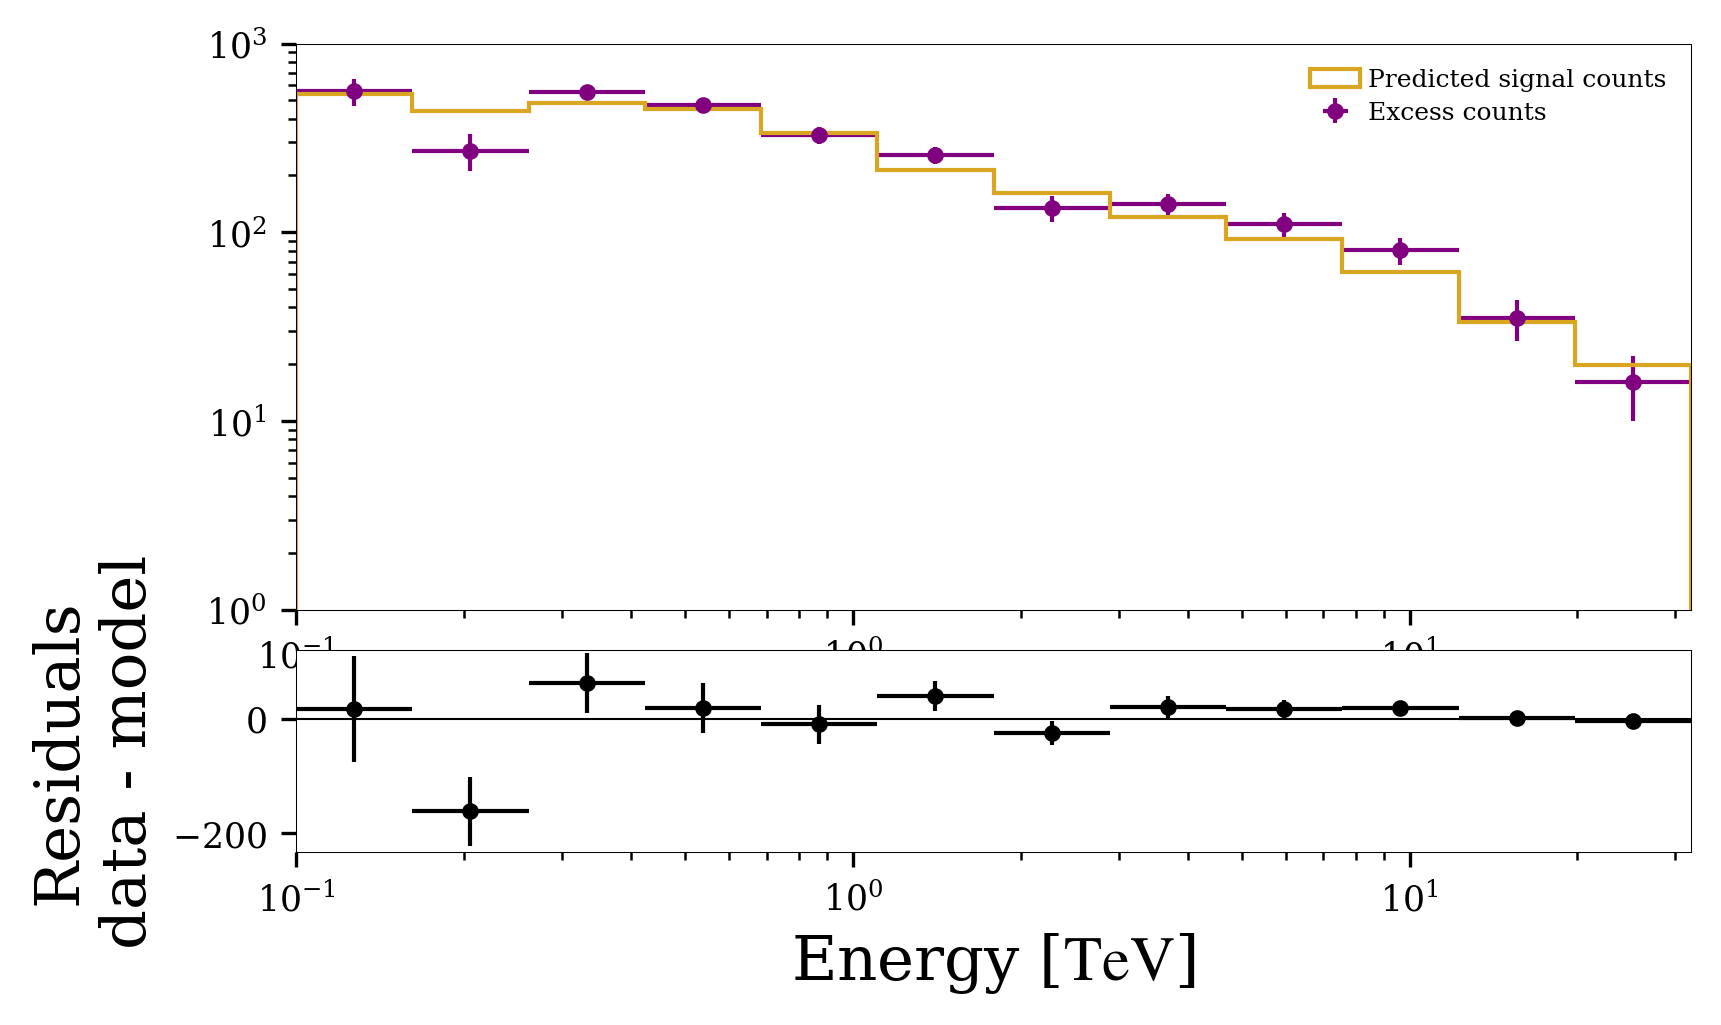

In [138]:
plt.figure()
ax_spectrum, ax_residuals = dataset_on_off.plot_fit()

In [140]:
print(dataset_on_off)

SpectrumDatasetOnOff
--------------------

  Name                            : dsBzctqG 

  Total counts                    : 19340 
  Total background counts         : 16387.05
  Total excess counts             : 2952.95

  Predicted counts                : 19344.32
  Predicted background counts     : 16385.82
  Predicted excess counts         : 2958.50

  Exposure min                    : 5.86e+09 m2 s
  Exposure max                    : 7.28e+11 m2 s

  Number of total bins            : 12 
  Number of fit bins              : 12 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 18.78

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index@2FrDAmnF

In [141]:
simulated_datasets = analysis.run_on_off(spectrum_dataset, dataset_on_off)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
obs-0,19512,3092.6015625,22.83340973759525,16419.3984375,16566.666901773875,16566.666901773875,nan,5860316160.0,727750803456.0,180000.0,180000.0,0.1084,0.09121888020833334,0.017181119791666668,12,12,wstat,811.5263411685182,328388,12.0,240.00001525878906,0.04999999701976776
obs-1,19294,2857.899999999998,21.137633588290576,16436.100000000002,16572.190476190473,16572.190476190473,nan,5860316008.7656765,727750832570.17,180000.0,180000.0,0.10718888888888889,0.09131166666666668,0.01587722222222221,12,12,wstat,677.7125001611148,328722,12.0,239.99999999999994,0.05000000000000001
obs-2,19178,2751.550000000003,20.37744763745598,16426.449999999997,16557.47619047619,16557.47619047619,nan,5860316008.7656765,727750832570.17,180000.0,180000.0,0.10654444444444444,0.09125805555555554,0.015286388888888905,12,12,wstat,730.3709452352505,328529,12.0,240.00000000000006,0.04999999999999999
obs-3,19360,2927.199999999997,21.637924363396454,16432.800000000003,16572.190476190477,16572.190476190477,nan,5860316008.7656765,727750832570.17,180000.0,180000.0,0.10755555555555556,0.09129333333333335,0.016262222222222206,12,12,wstat,723.1180701281555,328656,12.0,239.99999999999994,0.05000000000000001
obs-4,19405,2928.5499999999956,21.62053077866374,16476.450000000004,16615.90476190476,16615.90476190476,nan,5860316008.7656765,727750832570.17,180000.0,180000.0,0.10780555555555556,0.09153583333333336,0.0162697222222222,12,12,wstat,811.5307305291935,329529,12.0,239.99999999999991,0.05000000000000002
obs-5,19477,3058.2000000000007,22.58718362467434,16418.8,16564.42857142857,16564.42857142857,nan,5860316008.7656765,727750832570.17,180000.0,180000.0,0.10820555555555555,0.09121555555555555,0.016990000000000005,12,12,wstat,804.1381306890535,328376,12.0,240.00000000000003,0.049999999999999996
obs-6,19473,3035.9000000000015,22.41546616012121,16437.1,16581.666666666668,16581.666666666668,nan,5860316008.7656765,727750832570.17,180000.0,180000.0,0.10818333333333334,0.09131722222222222,0.01686611111111112,12,12,wstat,820.5178980579831,328742,12.0,240.00000000000003,0.049999999999999996
obs-7,19327,2910.0,21.524086451439732,16417.0,16555.571428571428,16555.571428571428,nan,5860316008.7656765,727750832570.17,180000.0,180000.0,0.10737222222222222,0.09120555555555555,0.016166666666666666,12,12,wstat,758.9376506309891,328340,12.0,240.0,0.05


In [146]:
simulated_datasets.models = [model_fit.copy('source')]

In [147]:
print(simulated_datasets.models)

DatasetModels

Component 0: SkyModel

  Name                      : source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index@2FrDAmnF                :      2.112   +/-    0.03             
    amplitude@5Hz4qIgw            :   1.40e-13   +/- 2.9e-14 1 / (MeV s cm2)
    reference@vE9k6tR6    (frozen):   1775.844       MeV         




In [148]:
simulated_datasets.models.names

['source']

In [149]:
results = []
fit = Fit()
for dataset in simulated_datasets.copy():
    # Do the 3D fit
    model_fit = model.copy(name="model-simu")
    spectral_model = model_fit.spectral_model
#     spectral_model.lambda_.min = 0
    dataset.models = [model_fit]

    fit_result = fit.run([dataset])

    if fit_result.success:
        _par_dict = {}
        _par_dict["irfs_opt"] = f'{irfs_opt}'
        _par_dict["success"] = fit_result.success

        for par in fit_result.parameters.free_parameters:
            _par_dict[par.name] = par.quantity

        sp_model = fit_result.models["model-simu"].spectral_model
#         Ec = 1./sp_model.lambda_.quantity
#         err = Ec**2 * sp_model.lambda_.error / u.TeV
#         _par_dict["ecut"] = Ec
#         _par_dict["ecut_err"] = err
        results.append(_par_dict)


# results_all.append(results)

In [150]:
simulated_datasets.models.names

['source']

In [151]:
flux_points_settings = analysis.config.flux_points
energy_settings = flux_points_settings.energy

In [152]:
energy_edges = MapAxis.from_energy_bounds(
    energy_settings.min,
    energy_settings.max, 
    nbin=energy_settings.nbins).edges

fpe = FluxPointsEstimator(
    energy_edges=energy_edges, 
    source='source', 
    selection_optional="all"
)
flux_points = fpe.run(datasets=simulated_datasets)

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

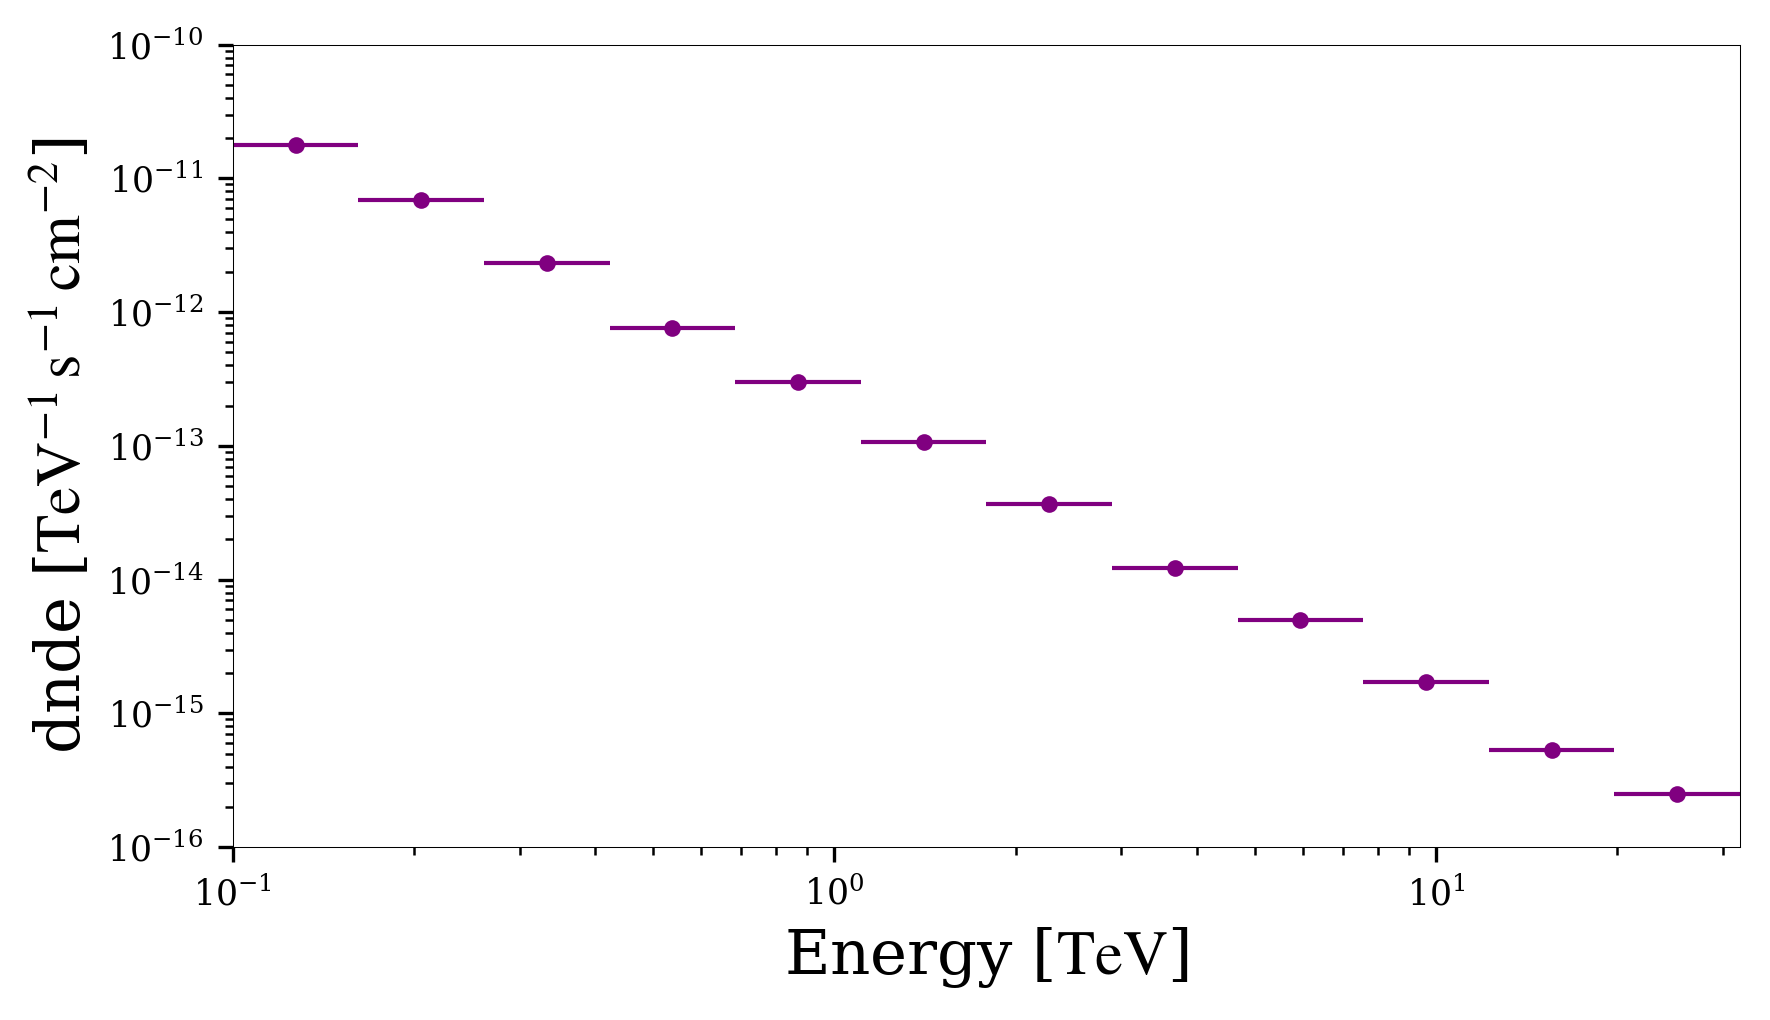

In [153]:
flux_points.plot()

In [164]:
dataset_cta = FluxPointsDataset(models=model_fit, data=flux_points, name=Irfs.get_irfs_label(irfs_opt))


(<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals\n (data - model) / model'>)

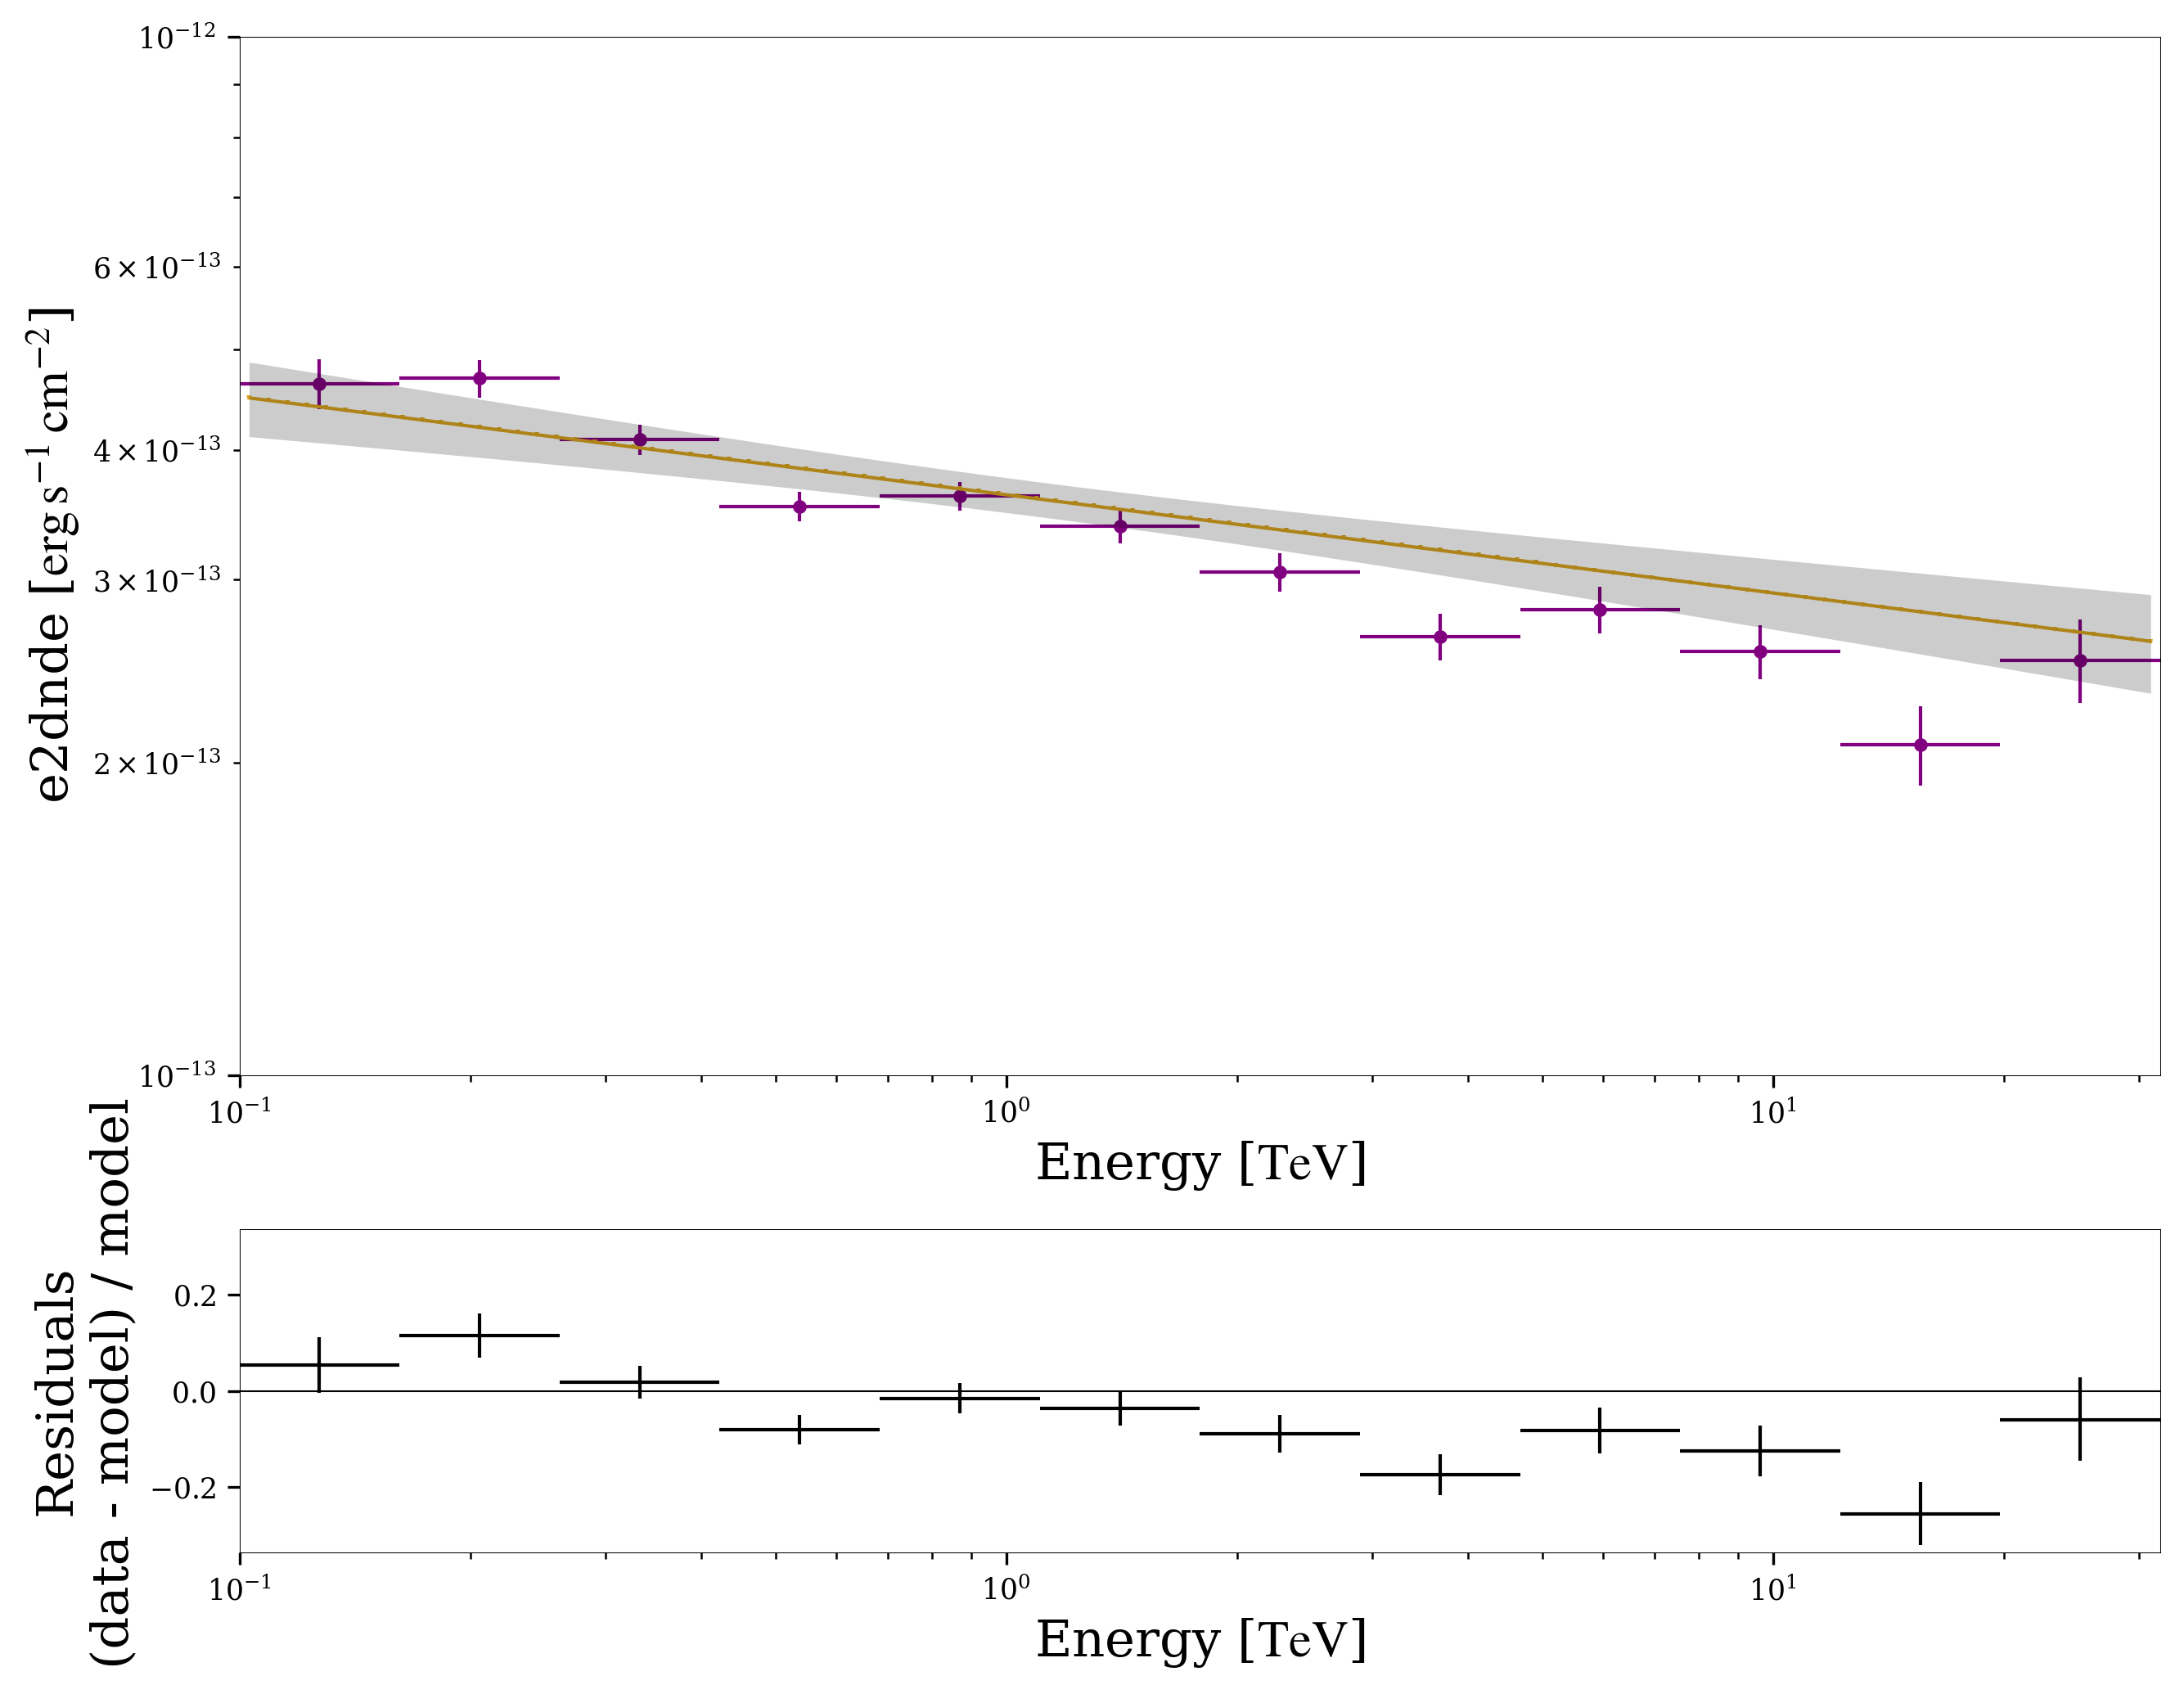

In [166]:
dataset_cta.plot_fit()

In [ ]:
n_obs = 100
config.observations.parameters.n_obs = n_obs

offset = 0.5*u.deg 
config.observations.parameters.offset = offset

config.observations.on_region_radius = on_region_radius

pointing_angle = 0*u.deg
config.observations.pointing_angle = pointing_angle

In [ ]:
pointing_position = create_pointing_position(position, pointing_angle, offset)
pointing = create_pointing(pointing_position)
print(f"{pointing}\n")

on_region = define_on_region(center=position, radius=on_region_radius)
print(f"{on_region}\n")

e_edges_min = 1.0e-01*u.TeV
e_edges_max = 3.2e+01*u.TeV
nbin_edges = 12
config.datasets.geom.axes.energy.min = e_edges_min
config.datasets.geom.axes.energy.max = e_edges_max
config.datasets.geom.axes.energy.nbins = nbin_edges
config.datasets.geom.axes.energy.name = 'energy'
energy_settings = config.datasets.geom.axes.energy

e_edges_min = 3.2e-02*u.TeV
e_edges_max = 1.0e+02*u.TeV
nbin_edges = 15
config.datasets.geom.axes.energy_true.min =  e_edges_min
config.datasets.geom.axes.energy_true.max = e_edges_max
config.datasets.geom.axes.energy_true.nbins = nbin_edges
config.datasets.geom.axes.energy_true.name = 'energy_true'
energy_true_settings = config.datasets.geom.axes.energy_true

energy_axis = create_energy_axis(
    energy_settings.min, 
    energy_settings.max, 
    energy_settings.nbins, 
    per_decade=True, 
    name=energy_settings.name
)

geom = create_region_geometry(on_region, axes=[energy_axis])
print(geom)
print(energy_axis)

energy_axis_true = create_energy_axis(
    energy_true_settings.min, 
    energy_true_settings.max, 
    energy_true_settings.nbins, 
    per_decade=True, 
    name=energy_true_settings.name
)


empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true, name='empty_dataset')
# analysis.datasets = Datasets(empty_dataset)
print(empty_dataset)

In [ ]:
spectrum_maker = SpectrumDatasetMaker(selection=selection)
sensitivity_estimator = SensitivityEstimator(
    gamma_min=gamma_min, n_sigma=n_sigma, bkg_syst_fraction=bkg_syst_fraction
)
sensitivity_estimator1 = SensitivityEstimator(
    gamma_min=gamma_min, n_sigma=n_sigma, bkg_syst_fraction=bkg_syst_fraction
)

In [ ]:
livetime = 50 * u.h

In [ ]:
Irfs.IRFS_OPTIONS

In [ ]:
irfs_config =[
    ['South', 'South-SSTSubArray','South-MSTSubArray','North','North-MSTSubArray', 'North-LSTSubArray'], 
    ['AverageAz'], 
    ['20deg','40deg','60deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(irfs_config)

In [ ]:
datasets = Datasets()
for i, (irfs_opt, irfs, irfs_label, location) in enumerate(zip(irfs_opts, irfss, irfs_labels, locations)):
    obs = Observation.create(
        pointing=pointing, irfs=irfs, livetime=livetime, location=location
    )
    print(obs)
    obs_label = get_obs_label(irfs_opt, offset, on_region_radius, livetime)
    print(obs_label)
    dataset = spectrum_maker.run(empty_dataset, obs)
    print(dataset)

    # correct exposure
    print('correct exposure')
    dataset.exposure *= containment
    print(dataset)

    # correct background estimation
    print('correct background estimation')
    on_radii = obs.psf.containment_radius(
        energy_true=energy_axis.center, 
        offset=offset, 
        fraction=containment
    )
    factor = (1 - np.cos(on_radii)) / (1 - np.cos(geom.region.radius))
    dataset.background *= factor.value.reshape((-1, 1, 1))
    print(dataset)

    print('create SpectrumDatasetOnOff')
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
        dataset=dataset, acceptance=acceptance, acceptance_off=acceptance_off
    )
    print(dataset_on_off)

    sensitivity_table = sensitivity_estimator.run(dataset_on_off)
    sensitivity_table.meta['source'] = source_name
    sensitivity_table.meta["offset"] = offset.to_string()
    sensitivity_table.meta["on_region_radius"] = f'{on_region_radius.deg}deg'
    sensitivity_table.meta["livetime"] = livetime.to_string()    
    sensitivity_table.meta["site"] = irfs_opt[0]
    sensitivity_table.meta["azimuth-averaged "] = irfs_opt[1]
    sensitivity_table.meta["zenith-angle"] = u.Quantity(irfs_opt[2]).to_string()
    sensitivity_table.meta["obs_time"] = u.Quantity(irfs_opt[3]).to_string()
    sensitivity_table.meta['irfs_label'] = irfs_label
    sensitivity_table.meta['irfs_config'] = irfs_opt
    sensitivity_table["on_radii"] = on_radii
    sensitivity_table["on_radii"].format = '.3e'
    label_table = f'sens-{irfs_label_txt(irfs_opt)}'
    label_dataset = f'sens {obs_label}'
    sensitivity_dataset = flux_points_dataset_from_table(sensitivity_table, name=label_dataset)
    datasets.append(sensitivity_dataset)
    print(sensitivity_table)
    print(dataset_on_off)

    dataset_on_off1 = dataset_on_off.to_image()

    sensitivity_table1 = sensitivity_estimator1.run(dataset_on_off1)
    print(sensitivity_table1)

    # To get the integral flux, we convert to a `FluxPoints` object that does the conversion
    # internally
    flux_points = FluxPoints.from_table(
        sensitivity_table1, sed_type="e2dnde", reference_model=sensitivity_estimator1.spectrum
    )
    int_sens = np.squeeze(flux_points.flux.quantity)
    print(
        f"Integral sensitivity in {livetime:.2f} above {e_edges_min:.2e} "
        f"is {int_sens:.2e}"
    )
    sensitivity_table.meta['int_sens'] = int_sens.to_string()
    write_tables_csv(
        sensitivity_table, sensitivity_path, label_table)

In [ ]:
datasets.write(f'{datasets_path}/sensitivity_datasets.yaml', overwrite=True)

In [ ]:
datasets_path

In [ ]:
datasets.extend(analysis.datasets)

In [ ]:
analysis.datasets = datasets

In [ ]:
analysis.write_datasets()